In [17]:
import os
from utilities import (extract_image_from_pdf, extract_xml_from_digital_pdf,
                       create_directory, read_directory_files, get_subdirectories,
                       get_string_xmltree, get_xmltree, get_specific_tags, get_page_texts_ordered,
                       get_page_text_element_attrib, get_ngram
                      )
from xml_document_info import (get_xml_info, get_xml_image_info)

from box_horizontal_operations import (merge_horizontal_blocks)
from box_vertical_operations import (merge_vertical_blocks)
from left_right_on_block import left_right_margin

import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import copy

from ocr_text_utilities import extract_text_from_image

## Draw the boxes on document pages

In [2]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

def show_df(df):
    return df.head(df.shape[0])

## start of program

In [96]:
base_dir   = '/home/naresh/Tesseract/document-structurelocal2/data'
#base_dir    = '/home/dhiraj/Documents/Anuwad/document-structure/data'

input_dir  = os.path.join(base_dir, 'input')
output_dir = os.path.join(base_dir, 'output')
#filename   = 'v241.pdf'
#filename   = 'downloaded.pdf'
#filename   = '20695_2010_8_1501_20635_Judgement_17-Feb-2020.pdf'
filename    = 'DELHI_HC_00001.pdf'

In [97]:
pdf_filepath   = os.path.join(input_dir, filename)
working_dir    = os.path.join(output_dir, os.path.splitext(filename)[0])

ret            = create_directory(working_dir)

pdf_image_dir  = extract_image_from_pdf(pdf_filepath, working_dir)
pdf_xml_dir    = extract_xml_from_digital_pdf(pdf_filepath, working_dir)

xml_files      = read_directory_files(pdf_xml_dir, pattern='*.xml')
# print(xml_files, "\n\n")
image_files    = read_directory_files(pdf_image_dir, pattern='*-*.jpg')
# print(image_files)
print("Extracted xml & images of file: %s" % (filename))

Extracted xml & images of file: DELHI_HC_00001.pdf


In [98]:
xml_dfs, page_width, page_height = get_xml_info(xml_files[0])
img_dfs, page_width, page_height = get_xml_image_info(xml_files[0])


Total number of pages (21) in file (DELHI_HC_00001.xml)
Total number of pages (21) in file (DELHI_HC_00001.xml)


In [99]:
document_configs = {
    'LANGUAGE_TYPE': 'eng',
    
    'HORI_BLOCK_WDTH_DIFF_PERC': 0.85,
    'SUPERSCRIPT_HEIGHT_DIFFERENCE': 7.0,
    'HORI_SPACE_TOO_CLOSE': 10.0,
    
    'VERTICAL_SPACE_TOO_CLOSE': 5.0,
    'AVERAGE_VERTICAL_SPACE': 12.0,
    'LEFT_OR_RIGHT_ALIGNMENT_MARGIN': 20.0
}

In [121]:
file_index     = 0
img_filepath   = image_files[file_index]
df             = xml_dfs[file_index]
img_df         = img_dfs[file_index]

In [122]:
show_df(img_df)

,index,text_top,text_left,text_width,text_height,base64,attrib
0,0,371,198,577,521,b'/9j/4AAQSkZJRgABAQEAYABgAAD/4QFYRXhpZgAATU0A...,IMAGE


# vertical spacings

In [123]:
#dataframe = main(image_files,xml_dfs, page_width, page_height,document_configs)

#####draw bounding boxes
#draw_bbox_coord(image_files, dataframe)

In [124]:
#dataframe

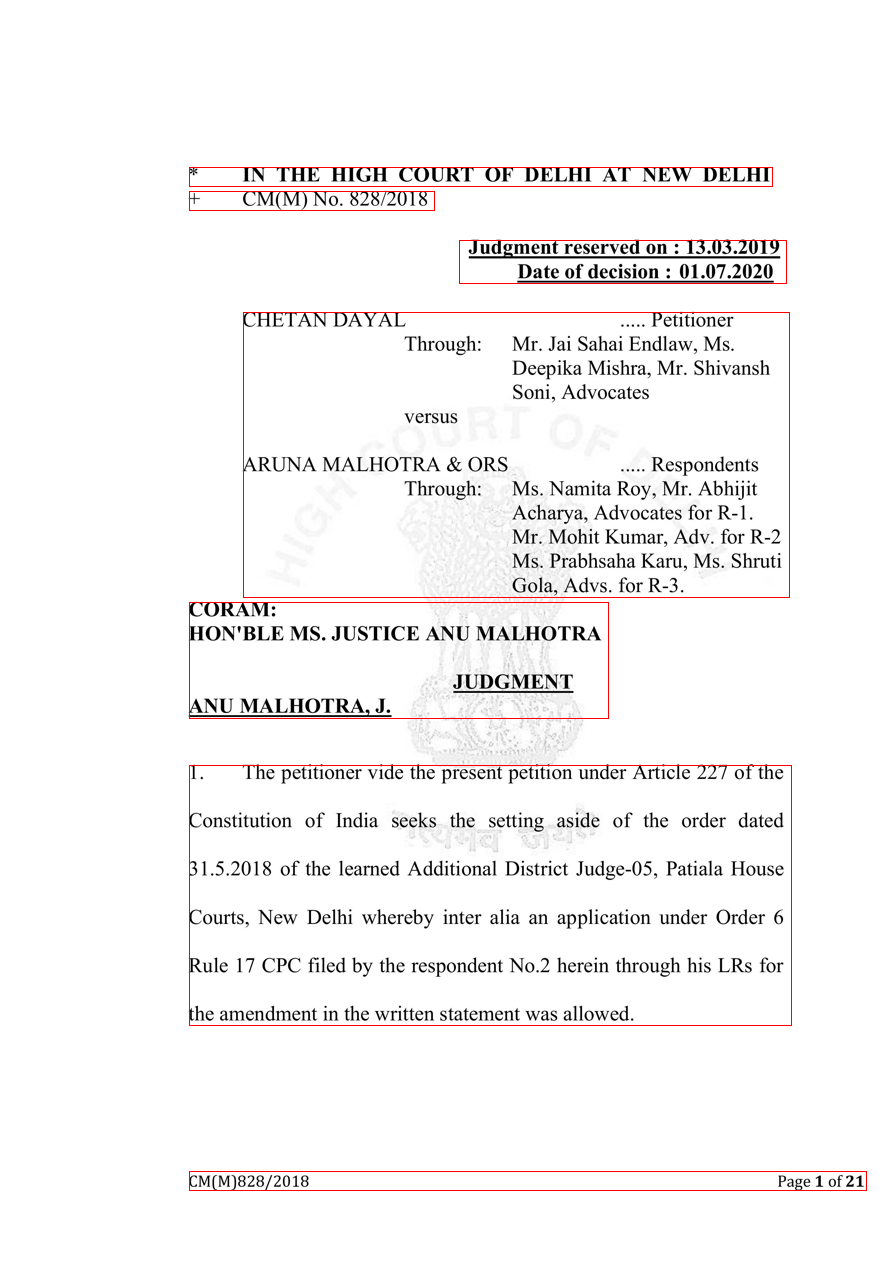

In [125]:
in_df   = df.loc[:]

h_df    = merge_horizontal_blocks(in_df, document_configs, debug=False)
v_df    = merge_vertical_blocks(h_df, document_configs, debug=False)

draw_box(img_filepath, page_width, page_height, v_df, color='red')
# show_df(h_df)


# logic for single block

In [126]:
block_configs = {
    "right_margin_threshold": 0.10,  "left_margin_threshold": 0.10,
    "right_break_threshold": 0.04,   "left_break_threshold": 0.05,
    "header_left_threshold": 0.70,  "header_right_threshold": 0.85,
    "space_multiply_factor": 1.8
}

In [127]:
def process_page_blocks(page_df, configs,block_configs, debug=False):
    cols      = page_df.columns.values.tolist()
    
    df        = pd.DataFrame(columns=cols)
    
    block_index = 0
    for index, row in page_df.iterrows():
        if row['children'] == None:
            df = df.append(page_df.iloc[index])
        else:
            dfs = process_block(page_df.iloc[index], block_configs)
            df = df.append(dfs)
    return df

In [128]:
def process_block(children, block_configs):
    
    dfs = left_right_margin(children, block_configs)
    return dfs

In [129]:
p_df = process_page_blocks(v_df, document_configs,block_configs)
#p_df = p_df.reset_index()
#p_df = p_df.drop(columns=['level_0','index'])

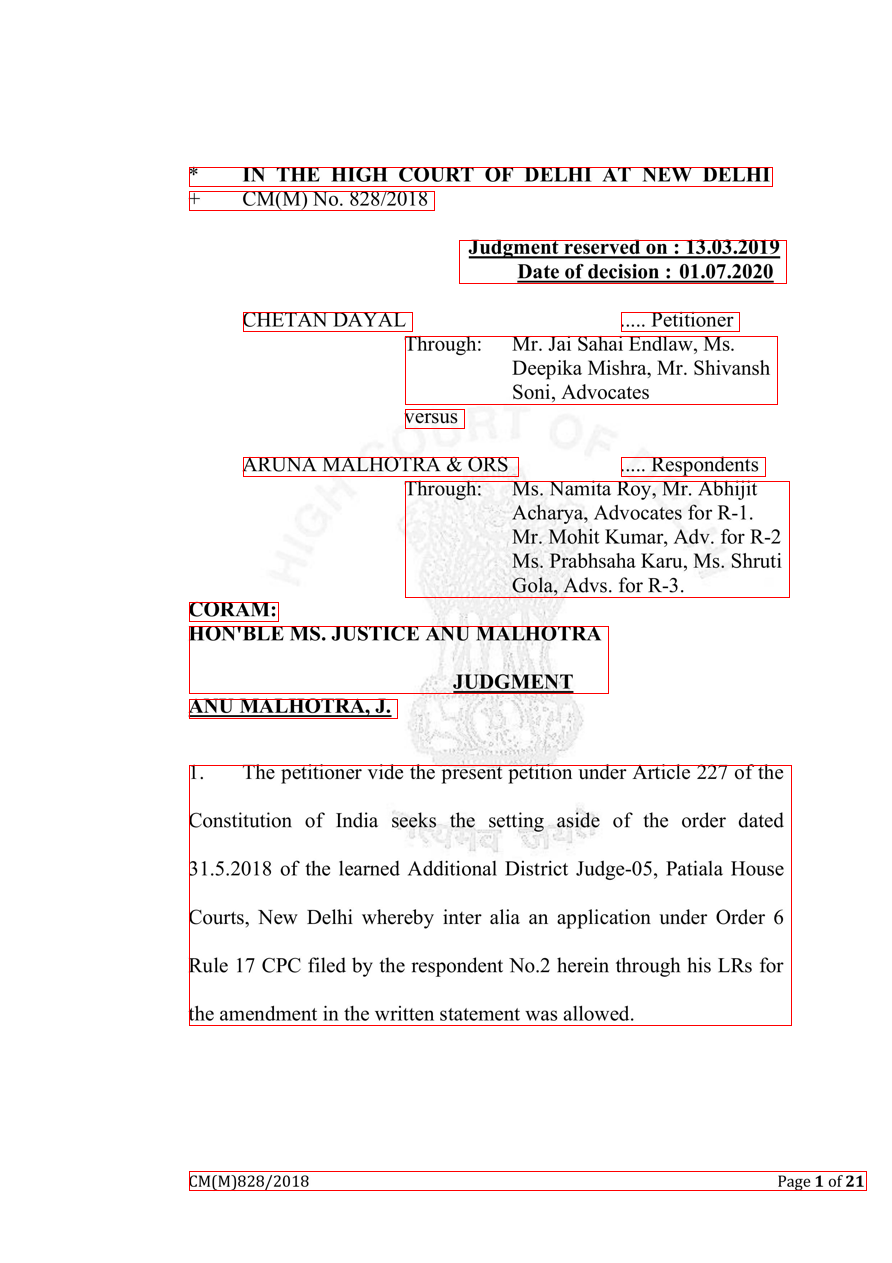

In [130]:
draw_box(img_filepath, page_width, page_height, p_df, color='red')

In [131]:
p_df

,index,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,attrib,children,level_0
0,0,5,167,189,583,19,* IN THE HIGH COURT OF DELHI AT NEW D...,21,TimesNewRomanPS,#000000,NaN,None,NaN
1,1,7,191,189,245,19,+ CM(M) No. 828/2018,21,TimesNewRomanPSMT,#000000,NaN,None,NaN
0,NaN,9,240,459,327,43,Judgment reserved on : 13.03.2019 Date of ...,21,TimesNewRomanPS,#000000,NaN,"{""level_0"":{""0"":2,""1"":3},""index"":{""0"":2,""1"":3}...",NaN
0,NaN,11,312,243,169,19,CHETAN DAYAL,21,TimesNewRomanPSMT,#000000,NaN,None,NaN
1,NaN,12,312,621,118,19,..... Petitioner,21,TimesNewRomanPSMT,#000000,NaN,None,NaN
2,NaN,13,336,405,372,68,"Through: Mr. Jai Sahai Endlaw, Ms. Deepika M...",21,TimesNewRomanPSMT,#000000,NaN,"{""level_0"":{""1"":5,""2"":6,""3"":7},""index"":{""1"":5,...",NaN
3,NaN,17,409,405,59,19,versus,21,TimesNewRomanPSMT,#000000,NaN,None,NaN
4,NaN,18,457,243,275,19,ARUNA MALHOTRA & ORS,21,TimesNewRomanPSMT,#000000,NaN,None,NaN
5,NaN,19,457,621,144,19,..... Respondents,21,TimesNewRomanPSMT,#000000,NaN,None,NaN
6,NaN,20,481,405,384,116,"Through: Ms. Namita Roy, Mr. Abhijit Acharya...",21,TimesNewRomanPSMT,#000000,NaN,"{""level_0"":{""6"":10,""7"":11,""8"":12,""9"":13,""10"":1...",NaN


In [133]:
def get_response(p_df,img_df,page_no,page_width,page_height):

    p_df['block_id'] = range(len(p_df))
    myDict = {'page_no': page_no,'page_width': page_width,'page_height':page_height,'image':{},'blocks':{}}
    image_data = process_image_df(myDict,img_df)
    myDict['image']=image_data
    page_data = df_to_json(p_df)
    myDict['blocks']=page_data
    return myDict


def df_to_json(p_df):
    page_data = []
    p_df  = p_df.where(p_df.notnull(), None)
    if len(p_df) > 0 :
        
        drop_col = ['index', 'xml_index','level_0']  
        for col in drop_col:
            if col in p_df.columns:
                p_df=p_df.drop(columns=[col])

        for index ,row in p_df.iterrows():
            block = row.to_dict()
            for key in block.keys():
                if key not in ['text', 'children']:
                    try :
                        block[key] = int(block[key])
                    except :
                        pass
            if 'children' in list(block.keys()):
                if block['children'] == None :
                    pass
                else :
                    block['text'] = None
                    block['children'] = df_to_json(pd.read_json(row['children']))
            page_data.append(block)
        
    return page_data

In [134]:
def process_image_df(myDict,img_df):
    image_data = []
    if len(img_df)>0:
        drop_col = ['index', 'xml_index','level_0']  
        for col in drop_col:
            if col in img_df.columns:
                img_df=img_df.drop(columns=[col])
                
        for index ,row in img_df.iterrows():
            block = row.to_dict()
            image_data.append(block)
        return image_data
    else:
        return None
    

In [135]:
final_json = get_response(p_df,img_df, 0,page_width,page_height)


In [136]:
final_json

{'page_no': 0,
 'page_width': 892,
 'page_height': 1263,
 'image': [{'text_top': 371,
   'text_left': 198,
   'text_width': 577,
   'text_height': 521,
   'base64': b'/9j/4AAQSkZJRgABAQEAYABgAAD/4QFYRXhpZgAATU0AKgAAAAgACAESAAMAAAABAAEAAAExAAIAAAAHAAAAbgEyAAIAAAAUAAAAdgE7AAIAAAAHAAAAihABAAQAAAABAAACARACAAQAAAABAAABz4dpAAQAAAABAAAAkpydAAEAAAAOAAABQgAAAABQaWNhc2EAADIwMTI6MDk6MTcgMTc6NTA6MDgAUGljYXNhAAAACJAAAAcAAAAEMDIyMJADAAIAAAAUAAAA+JAEAAIAAAAUAAABDJKRAAIAAAADMDAAAJKSAAIAAAADMDAAAKACAAQAAAABAAACAaADAAQAAAABAAABz6QgAAIAAAAhAAABIAAAAAAyMDEyOjA5OjE3IDE0OjU4OjEzADIwMTI6MDk6MTcgMTQ6NTg6MTMAZDlkNjVkY2Y3ZWFmMjYxZWFlN2ZjMjNmMjdhMmM3OTkAAFAAaQBjAGEAcwBhAAAA/9sAQwAIBgYHBgUIBwcHCQkICgwUDQwLCwwZEhMPFB0aHx4dGhwcICQuJyAiLCMcHCg3KSwwMTQ0NB8nOT04MjwuMzQy/9sAQwEJCQkMCwwYDQ0YMiEcITIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIy/8AAEQgBzwIBAwEiAAIRAQMRAf/EAB8AAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKC//EALUQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnK